In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#tf.debugging.set_log_device_placement(True)

In [2]:
'''
PROGRAM SET UP: 
To switch between classifications: binary (2), categories (5), and types (23)

(not fully implemented / not sure if necessary)
'''

# Change me for other classifications!
# binary, categories, or types
# --------------------------------------------------
SCOPE = 'binary'
# --------------------------------------------------


DOS_TYPES = ('back','land','neptune','pod','smurf','teardrop')
U2R_TYPES = ('buffer_overflow','loadmodule','perl','rootkit')
R2L_TYPES = ('ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster')
PROBE_TYPES = ('ipsweep','nmap','portsweep','satan')

# i promise this has a purpose
attack_dict = dict(normal ='normal')
[attack_dict.setdefault(each, 'dos') for each in DOS_TYPES]
[attack_dict.setdefault(each, 'u2r') for each in U2R_TYPES]
[attack_dict.setdefault(each, 'r2l') for each in R2L_TYPES]
[attack_dict.setdefault(each, 'probe') for each in PROBE_TYPES]

num_classifications = {'binary' : 2, 'categories' : 5, 'types' : 23}

try:
    N_CLASS = num_classifications[SCOPE]
except KeyError as ke:
    print('Scope chosen does not match available options (check spelling)')

In [3]:
try:
    #path = get_file('kddcup.data.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz')
    #path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
    path = './nslkdd/KDDTrain+.txt'
except:
    print('Error downloading')
    raise
    
df = pd.read_csv(path, header=None)
print("Read {} rows into dataframe.".format(len(df)))

# Sample only 1% of the dataset
#df = df.sample(frac=0.01, replace=False)

# Drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 

columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

if path == './nslkdd/KDDTrain+.txt':
    columns.append('difficulty_rating')
    
df.columns = columns


Read 125973 rows into dataframe.


In [4]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [5]:
class_columns = ['difficulty_rating', 'outcome']

# Quantitative - numeric/continuous values
to_zscore = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 
            'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 
            'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
            'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 
            'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
            'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
            'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
            'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
            'dst_host_srv_rerror_rate']

# Qualitative - nominal/binary features
to_dummy = ['protocol_type',
            'service',
            'flag',
            'land',
            'logged_in',
            'is_host_login',
            'is_guest_login']

# Transformations: Encode the feature vector
for each in to_zscore: encode_numeric_zscore(df, each)
for each in to_dummy: encode_text_dummy(df, each)

In [6]:
# CHECK: display 5 rows & classification counts in dataset
# print(df[0:5])
# print(df['outcome'].nunique())
# print(df.groupby('outcome')['outcome'].count())

In [7]:
def set_bin_class(df):
    '''Binary Classification'''
    for i, row in df.iterrows():
        if row['outcome'].split('.')[0] != 'normal':
            df.at[i, 'outcome'] = 1
        else:
            df.at[i, 'outcome'] = 0
            
def set_category_class(df):
    '''For categorical attack classification'''        
    for i, row in df.iterrows():
        val = row['outcome'].split('.')[0]
        df.at[i, 'outcome'] = attack_dict[val]
    return    
    
def convert_to_numpy(df_trainer):
    # Convert to numpy - Classification
    x_columns = df_trainer.columns.drop(class_columns)
    x = df_trainer[x_columns].values
    dummies = pd.get_dummies(df_trainer['outcome']) # Classification

    outcomes = dummies.columns
    num_classes = len(outcomes)
    y = dummies.values
    
    return x, y, num_classes

df.dropna(inplace=True,axis=1)

if SCOPE == 'binary': set_bin_class(df)
elif SCOPE == 'categories': set_category_class(df)
elif SCOPE == 'types': pass

# This is the numeric feature vector, as it goes to the neural net
df_trainer = None

# Sampling method to include all classifications of interest
num_classes = 0
while num_classes != N_CLASS: 
                                                    # do we still want this? 
    df_trainer = df.sample(frac=1.0, replace=False) # Uncomment this line to sample only 10% of the dataset
    x, y, num_classes = convert_to_numpy(df_trainer)

print(f'Performing {SCOPE} Classification')

Performing binary Classification


In [8]:
'''Create tests and training sets'''
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [9]:
'''NEURAL NETWORK'''

def baseline_model():
    '''
    'linear' - activation takes weights*input and outputs signal proportional to the input
    'softmax' - normalized exponential activation (large input = much larger output)
    'adam' - extension to stochastic gradient descent
    '''
    model = Sequential()
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=50, verbose=0)

In [10]:
'''Train NN'''
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=50)

Train on 94479 samples, validate on 31494 samples
Epoch 1/50
94479/94479 - 9s - loss: 0.0948 - accuracy: 0.9687 - val_loss: 0.0806 - val_accuracy: 0.9731
Epoch 2/50
94479/94479 - 8s - loss: 0.0801 - accuracy: 0.9717 - val_loss: 0.0767 - val_accuracy: 0.9737
Epoch 3/50
94479/94479 - 9s - loss: 0.0767 - accuracy: 0.9724 - val_loss: 0.0781 - val_accuracy: 0.9727
Epoch 4/50
94479/94479 - 11s - loss: 0.0773 - accuracy: 0.9727 - val_loss: 0.0746 - val_accuracy: 0.9724
Epoch 5/50
94479/94479 - 7s - loss: 0.0752 - accuracy: 0.9724 - val_loss: 0.0736 - val_accuracy: 0.9745
Epoch 6/50
94479/94479 - 8s - loss: 0.0753 - accuracy: 0.9723 - val_loss: 0.0731 - val_accuracy: 0.9754
Epoch 7/50
94479/94479 - 10s - loss: 0.0745 - accuracy: 0.9724 - val_loss: 0.0731 - val_accuracy: 0.9741
Epoch 8/50
94479/94479 - 8s - loss: 0.0752 - accuracy: 0.9726 - val_loss: 0.0752 - val_accuracy: 0.9737
Epoch 9/50
94479/94479 - 6s - loss: 0.0733 - accuracy: 0.9727 - val_loss: 0.0751 - val_accuracy: 0.9746
Epoch 10/50


In [11]:
import numpy as np
from sklearn import metrics

def validation_score(x, y):
    y_eval = np.argmax(y, axis=1)
    pred = estimator.predict(x)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))
    return

In [12]:
validation_score(x_test, y_test)

Validation score: 0.9731694926017654


In [13]:
validation_score(x, y)

Validation score: 0.9725496733427004


In [14]:
'''RANDOM FOREST'''

#from sklearn.neural_network import MLPClassifier
#mlp = MLPClassifier(hidden_layer_sizes=(64,64,),max_iter=50,verbose=True)
#mlp.fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=1)
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.1s finished


In [15]:
results = []
for val in y_test:
    results.append(val[0])

In [20]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

PC1 = 'principal component 1'
PC2 = 'principal component 2'

def PCA_method():
    '''
    PRINCIPAL COMPONENT ANALYSIS
    ----------------------------
    (IDEA) for 'categories'
        since PCA sucks at nonbinary classing- how about:
            normal vs dos
            normal vs ur2
            normal vs r2l
            normal vs probe
        we end up with 4 graphs

        this should (kw: should) be easy using the set_bin_class() on a dataframe pulling from just those categories,
        i.e. 
                for_PCA = set_bin_class(df['dos'] + df['normal'])

    If yes let's tack this down as later goal
    I'm also perfectly happy leaving PCA for just binary lol
    -jp
    '''
    # CHECK 
    #predictions = mlp.predict(x_test)
    #print(confusion_matrix(y_test, predictions))
    #print(classification_report(y_test,predictions))
    pca = PCA(n_components = 2)
    principalComponents = pca.fit_transform(x_test)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = [PC1, PC2])

    '''
    prepares true_normal_df for visualization; to compare against 
    the two groups generated by K-Means Clustering.
    '''
    true_normal_df = principalDf.copy()                                                     #copy PCA1, PCA2 columns from principalDf (original df) into new true_normal_df
    true_normal_df['outcome'] = results                                                     #copy outcome column from original df to true_normal_df
    true_normal_df = true_normal_df.drop(true_normal_df[true_normal_df.outcome != 1].index) #delete all rows from true_normal_df with outcome != 'normal'
    true_normal_df.drop(['outcome'], axis = 1)                                              #drop outcome column from the true_normal_df, 
                                                                                            #leaves PCA1 & PCA2 cols that correspond to true normal rows (for plot)
    # CHECK - every outcome in our table is normal
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        outcome_count = len(true_normal_df['outcome'])
        normal_count = (true_normal_df.outcome == 'normal').sum()
        print(outcome_count, normal_count == 0 or normal_count == outcome_count) 
    return principalDf, true_normal_df


16668 True


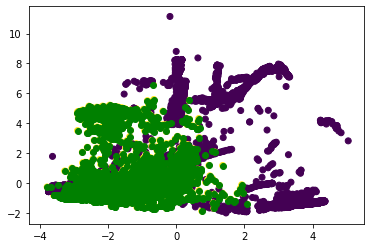

In [21]:
if SCOPE == 'binary':
    principalDf, true_normal_df = PCA_method()
    
    # Plot PCA
    scatter = plt.scatter(principalDf[PC1], principalDf[PC2], c = results, cmap = 'viridis')
    plt.scatter(true_normal_df[PC1], true_normal_df[PC2], color = 'g', alpha = 1)
    plt.show()